# End-to-end demand forecasting workflow with DataRobot and Databricks 

Authors: Austin Chou, Andrew Mathis

Reference: [DataRobot API documentation](https://docs.datarobot.com/en/docs/api/reference/index.html)

## Summary

This notebook outlines a use case forecasting future sales for multiple stores via multiseries modeling. Multiseries modeling allows you to model datasets that contain multiple time series based on a common set of input features. As in this example, multiseries forecasting is often useful for large chain businesses that want to more accurately manage their inventory and staffing by predicting the sales volume in the future. 

This notebook focuses on working with Databricks and walks through how to use the Python API client to:

1. Connect to DataRobot
2. Import data from Databricks into the AI Catalog
3. Create a time series forecasting project and run Autopilot
4. Retrieve and evaluate model performances and insights
5. Make new predictions with a test dataset
6. Deploy a model with monitoring in MLOps
7. Forecast predictions via the Prediction API

For this walkthrough, you can use the following publicly available dataset from the public DataRobot S3 bucket. Datasets for the excercise can be downloaded from here:

* [Multiseries sales forecasting - Training data](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/DR_Demo_Sales_Multiseries_training.csv)
* [Multiseries sales forecasting - Predictions data](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/DR_Demo_Sales_Multiseries_prediction.csv)

## Setup

### Import libraries

In [0]:
# DataRobot Python library
import datarobot as dr

# The following are libraries used in this notebook for data and model evaluation
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

#### Optional: Import public training data for walkthrough (If data not already available in Databricks)

For this walkthrough, you can usea publicly available dataset ('DR_Demo_Sales_Multiseries_training.csv') from the public DataRobot S3 bucket to create a temporary table in Databricks. This will let you run the cells in this notebook and follow along.

In [0]:
# Pull data from public DataRobot datasets
# Training Dataset
data_path = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/DR_Demo_Sales_Multiseries_training.csv"
pd_df = pd.read_csv(data_path,
                    infer_datetime_format=True,
                    engine='c')

# Convert into Spark DataFrame
# For demo purposes, we'll create a local temporary view
spark_df = spark.createDataFrame(pd_df)
spark_df.createOrReplaceTempView("Sales_Multiseries_training")


# Test Dataset
data_path = "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/DR_Demo_Sales_Multiseries_prediction.csv"
pd_df = pd.read_csv(data_path,
                    infer_datetime_format=True,
                    engine='c')

# Convert into Spark DataFrame
# For demo purposes, we'll create a local temporary view
spark_df = spark.createDataFrame(pd_df)
spark_df.createOrReplaceTempView("Sales_Multiseries_prediction")

## Connect to DataRobot

To connect to DataRobot, you need to provide your API token and the endpoint. For more information, please refer to the following documentation:

- [Create and manage API keys via developer tools in the GUI](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management)
- [Different options to connect to DataRobot from the API client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)

Your API token can be found in the DataRobot UI in the **Developer tools** section, accessed from the profile menu in the top right corner. Copy the API token and paste in the cell below.

In [0]:
# Connect to the DataRobot client
# API Token
DATAROBOT_API_TOKEN = 'INSERT YOUR DATAROBOT API TOKEN' # You can find the API token under the Developer Tools in the UI

# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = 'https://app.datarobot.com/api/v2' # If you have another endpoint (e.g. on-prem installs), change this accordingly

# Connect to client
dr.Client(
  token=DATAROBOT_API_TOKEN, 
  endpoint=DATAROBOT_ENDPOINT
)

Out[3]: <datarobot.rest.RESTClientObject at 0x7f28cd3acbe0>

## Import data from Databricks into the AI Catalog

Currently, DataRobot supports ingesting data via (1) pulling the data into a notebook, converting to a pandas dataframe, and then ingesting to DataRobot OR (2) directly ingesting data via JDBC connection to your Databricks data source.

We will demonstrate the first approach here. For large datasets, we recommend the second approach in order to bypass the need to convert the PySpark dataframe into a Pandas dataframe. ([Click here for documentation on setting up data connections and data sources for direct ingest.](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html))

In [0]:
# Query and prepare data for ingest
training_df = spark.sql(""" SELECT * FROM Sales_Multiseries_training """)

# Convert to pandas df
training_df = training_df.toPandas()

# For time-series projects, DataRobot expects a dataset that is ordered by our Multi-series ID (e.g. Store) and Date
# Prepare our dataframe accordingly:
training_df[["Date"]] = training_df[["Date"]].apply(pd.to_datetime) # Convert Date to datetime
training_df = training_df.sort_values(by=['Store','Date']) # Order

training_df.head(5)

Out[4]:

,Store,Date,Sales,Store_Size,Num_Employees,Num_Customers,Returns_Pct,Pct_On_Sale,Pct_Promotional,Marketing,TouristEvent,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
5712,Baltimore,2012-07-01,40669,15100,20,170,1.15,10.11,0.000047,July In Store Credit Card Signup Discount; In ...,No,0.5,NaN,0.02
5713,Baltimore,2012-07-02,35360,15100,12,152,0.46,8.78,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
5714,Baltimore,2012-07-03,40741,15100,10,185,0.35,9.09,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
5715,Baltimore,2012-07-04,33871,15100,16,182,0.93,10.23,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
5716,Baltimore,2012-07-05,36880,15100,19,155,0.56,9.95,0.000047,July In Store Credit Card Signup Discount; ID5...,No,NaN,NaN,NaN


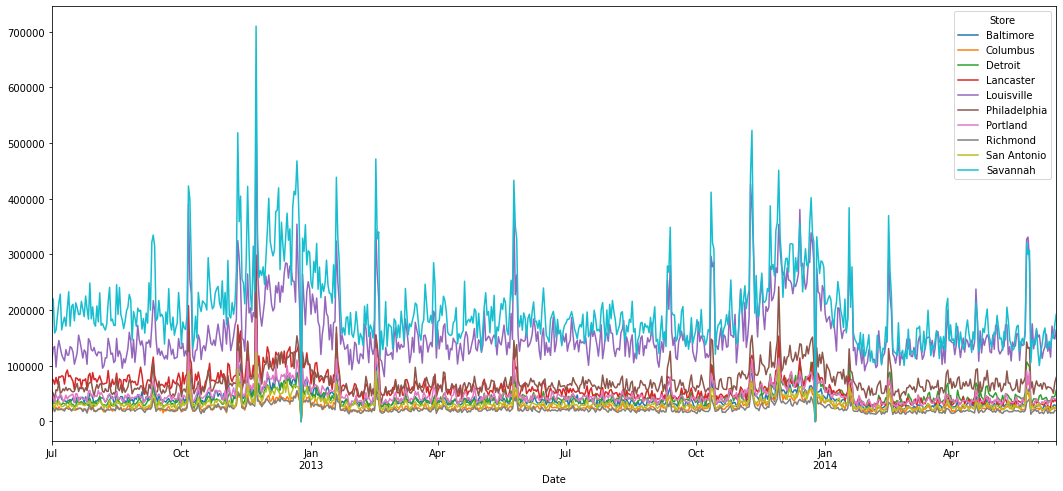

In [0]:
# Let's also visualize our data:
training_df.pivot(index='Date', columns='Store', values='Sales').plot(figsize=(18, 8))
plt.show()

In [0]:
# Upload data to DataRobot AI Catalog
new_dataset = dr.Dataset.upload(source=training_df)

# Update the dataset name in the AI Catalog
new_dataset.modify(name="[AIA] Sales_Multiseries_training")

Datasets in the AI Catalog are assigned a **dataset ID** which you can use to reference/get the dataset via the API.

In [0]:
# Quick link to the AI Catalog dataset you just created
print("AI Catalog URL: " + new_dataset.get_uri())
print("Dataset ID: " + new_dataset.id)

AI Catalog URL: https://app.datarobot.com/ai-catalog/6505fd9a6e7f0601aa806be7
Dataset ID: 6505fd9a6e7f0601aa806be7

## Create a time series forecasting project and run Autopilot

You can **create DataRobot projects** directly from:

* A dataset in AI Catalog (using the dataset's ID in DataRobot)
* A pandas dataframe (you do not need to write back to a data source or disk)
* Directly from data sources

Once a project is created, you can tune and iterate on various modeling options (time series modeling, partition details, accuracy metrics, feature lists, etc.) and start modeling. For time series, these models can range from integrated models (Arima, RNNs), per forecast distance models (XGboost, elastic net), Trends and decomposition models, and more. In addition to this, the modeling process will also create and explore various time-series features - baseline features, rolling statistics, seasonal features based on date time, etc.

You can actively watch the project in action in the DataRobot UI after initiating Autopilot. The API and UI are parallel gateways to working on the same project which allows for cross-functional collaboration.

Each created project is associated with a unique project ID. You can use the project ID to retrieve the project of interest via the API later on.

Reference the following resources for more information about time series modeling projects:
* [Python API reference](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/spec/time_series.html)
* [Time Series modeling framework](https://docs.datarobot.com/en/docs/modeling/time/ts-reference/ts-framework.html)

### Create a project

We create a project using our dataset in the AI Catalog:

In [0]:
# Create a new DataRobot project
project = dr.Project.create_from_dataset(
  project_name='[AIA] Multi_Store_Sales_Forecast', 
  dataset_id=new_dataset.id
)

DataRobot Projects are assigned a **project ID** which you can use to reference/get the dataset via the API.

In [0]:
# Quick link to the DataRobot project you just created
# Note: the get_uri for projects goes to the Model tab. This won't be populated yet since we haven't run Autopilot.
# Switch to the Data tab in the UI after following the url to get to the project setup section.
print("DataRobot Project URL: " + project.get_uri())
print("Project ID: " + project.id)

DataRobot Project URL: https://app.datarobot.com/projects/6505fe26bd0c2a195d1a77a4/models
Project ID: 6505fe26bd0c2a195d1a77a4

### Configure time-series modeling settings

Time-series projects have a number of parameters we can adjust. This includes:

* Multi-series (i.e. Series ID column)
* Backtest partitioning
* Feature Derivation Window
* Forecast Window
* Known-in-advance (KA) Variables
* Do not derive (DND) Variables
* Calendars

We will set a number of these parameters. Additional information can be referenced in the [Time series modeling documentation](https://docs.datarobot.com/en/docs/modeling/time/ts-flow-overview.html). Here are some initial parameters to get started:

**What rolling window should DataRobot use to derive features?** 

The Feature Derivation window (FDW) represents the rolling window that is used to derive time series features and lags, relative to the Forecast Point (i.e. date of prediction). For example, we will build features within the rolling window of last 35 days in this accelerator.

**Which future values do you want to forecast?**

The Forecast Window (FW) represents the rolling window of future values to predict, relative to the Forecast Point. For example, to predict sales for next 7 days, we enter 1 to 7 days. ([Click here for additional documentation on FDW and FW.](https://docs.datarobot.com/en/docs/modeling/time/ts-adv-modeling/ts-customization.html#set-window-values))

**What are ["Known-in-advance" (KA) features](https://docs.datarobot.com/en/docs/modeling/time/ts-adv-modeling/ts-adv-opt.html#set-known-in-advance-ka)?**

KA features are variables that you know in advance and can use as inputs for that row at the time of prediction. For example, our marketing team will already set the marketing campaign ahead of each date, so we do not need to lag the Marketing feature (i.e. Marketing is a KA feature).

**How can we include special calendar events during feature engineering?**

You can [generate or upload a customized calendar](https://docs.datarobot.com/en/docs/modeling/time/ts-adv-modeling/ts-adv-opt.html#calendar-files) to the project. DataRobot will include additional feature engineering based on the calendar as part of the time-series feature engineering process.

In [0]:
# Set Time Series Parameters
# Feature Derivation Window
# What rolling window should DataRobot use to derive features? 
FDW = [(-35,0)]

# Forecast Window
# Which future values do you want to forecast? (i.e. Forecast Distances)
FW  = [(1,7)]

# Known In Advance features
# Features that will be known at prediction time - all other features will go through an iterative feature engineering and selection process to create time-series features.
FEATURE_SETTINGS = []
KA_VARS   = ['Store_Size', 'Marketing', 'TouristEvent']
for column in KA_VARS:  
    FEATURE_SETTINGS.append(dr.FeatureSettings(column, known_in_advance=True, do_not_derive=False))

# Calendar
# Create a calendar file from a dataset to see how specific events by date contribute to better model performance
CALENDAR = dr.CalendarFile.create_calendar_from_country_code(country_code='US',
                                                             start_date=min(training_df['Date']), # Earliest date in calendar
                                                             end_date=max(training_df['Date'])) # Last date in calendar

We pass all our settings to a [DatetimePartitioningSpecification](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/spec/datetime_partition.html?highlight=datetimepartitioningspecification#setting-up-a-datetime-partitioned-project) object which will then be passed to our Autopilot process.

In [0]:
# Create DatetimePartitioningSpecification
# The DatetimePartitioningSpecification object is how we pass our settings to the project
time_partition = dr.DatetimePartitioningSpecification(
  # General TS settings
  use_time_series           = True,
  datetime_partition_column = 'Date', # Date column
  multiseries_id_columns    = ['Store'], # Multi-series ID column
  
  # FDW and FD
  forecast_window_start     = FW[0][0], 
  forecast_window_end       = FW[0][1],
  feature_derivation_window_start = FDW[0][0],
  feature_derivation_window_end   = FDW[0][1],

  # Advanced settings
  feature_settings          = FEATURE_SETTINGS,
  calendar_id               = CALENDAR.id
)

### Start modeling with autopilot

To start the Autopilot process, call the `analyze_and_model` function. Provide the prediction target and our DatetimePartitioningSpecification as part of the function call. We have several modes to spin up Autopilot - in this demo, we will use the default "Quick" mode.

In [0]:
# Start Autopilot
project.analyze_and_model(
  # General parameters
  target = 'Sales',   # Target to predict
  worker_count = -1,   # Use all available modeling workers for faster processing
  # TS options
  partitioning_method = time_partition, # Feature settings
)

Out[12]: Project([AIA] Multi_Store_Sales_Forecast)

In [0]:
# If you want to wait for Autopilot to finish, run this code
# You can set verbosity to 1 if you want to print progress updates as Autopilot runs
project.wait_for_autopilot(verbosity=0)

## Retrieve and evaluate model performances and insights

After Autopilot completes, you can easily evaluate your model results. Evaluation can include compiling the Leaderboard as a dataframe, measuring performances across different backtest partitions with different metrics, visualizing the accuracy across series, analyzing Feature Impact and Feature Effects to understand each models' behaviors, and more. This can be done for every single model created by DataRobot.

As a simple example in this notebook, **we identify the best model created by Autopilot and evaluate:**

* RMSE performance
* MASE performance
* Accuracy for Time for various Forecast Distance and Series combinations
* Feature Impact of Top 10 features
* Compare Accuracy across Series

In [0]:
# # For convenience, we can access the project directly with the project ID:
# project = dr.Project.get(project_id='65021b8e737ea778d21a78d8')

In [0]:
# Identify the best model by the optimization metric
metric_of_interest = project.metric

# Get all models
all_models = project.get_datetime_models()

# Extract models that have a "All Backtests" performance evaluation for our metric
best_models = sorted(
                    [model for model in all_models if model.metrics[project.metric]['backtesting']],  
                    key=lambda m: m.metrics[project.metric]['backtesting'],
                    )

# Iterate through the models and extract model metadata and performance
scores = pd.DataFrame()

for m in best_models:
    model_performances = pd.DataFrame(
        [
            {
                'Project_Name': project.project_name,
                'Project_ID': project.id,
                'Model_ID': m.id,
                'Model_Type': m.model_type,
                'Featurelist': m.featurelist_name,
                'Optimization_Metric': project.metric,
                'Partition': 'All backtests',
                'Value': m.metrics[project.metric]['backtesting'],
            }
        ]
    )
    scores = scores.append(model_performances, sort=False).reset_index(drop=True)  
    
# Sort by performance value
scores = scores.sort_values(by='Value',
                            ascending=True) # Sort ascending so best model (lowest RMSE) is first 
scores

Out[14]:

,Project_Name,Project_ID,Model_ID,Model_Type,Featurelist,Optimization_Metric,Partition,Value
0,[AIA] Multi_Store_Sales_Forecast,6505fe26bd0c2a195d1a77a4,6506004a90dab7973c0924e8,Temporal Hierarchical Model with Elastic Net a...,With Differencing (average baseline),RMSE,All backtests,17292.63525
1,[AIA] Multi_Store_Sales_Forecast,6505fe26bd0c2a195d1a77a4,6506004a90dab7973c0924e9,eXtreme Gradient Boosted Trees Regressor with ...,With Differencing (average baseline),RMSE,All backtests,17781.39036
2,[AIA] Multi_Store_Sales_Forecast,6505fe26bd0c2a195d1a77a4,6506004a90dab7973c0924de,Ridge Regressor with Forecast Distance Modelin...,No Differencing,RMSE,All backtests,19125.49672
3,[AIA] Multi_Store_Sales_Forecast,6505fe26bd0c2a195d1a77a4,6506004a90dab7973c0924e5,Ridge Regressor with Forecast Distance Modelin...,With Differencing (7 day),RMSE,All backtests,20812.57310


In [0]:
# Select the top model in our project for further evaluation
top_model = dr.Model.get(project=project.id,
                         model_id=scores['Model_ID'][0])

# Quick link to the recommended model built by Autopilot
print("Top Model URL: " + top_model.get_uri())
print("Top Model Type: " + top_model.model_type)

Top Model URL: https://app.datarobot.com/projects/6505fe26bd0c2a195d1a77a4/models/6506004a90dab7973c0924e8
Top Model Type: Temporal Hierarchical Model with Elastic Net and XGBoost

### Model performance by metric

As a demonstration, we will get the performance of our model for:

* **RMSE**: The optimization metric used by Autopilot in this project. We could have used another optimization metric when we kicked off the autopilot process with "analyze_and_model").
* [**MASE (Mean Absolute Scaled Error)**](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html#mase): Autopilot automatically uses a naive baseline model (e.g. using most recent value as the forecasted value) and scales the error to the naive model. MASE < 1 means an improvement over baseline, whereas MASE > 1 means the model performs worse than the naive approach (e.g. just taking the most recent value).

In [0]:
print("Top Model RMSE performance (All Backtests): " + str(top_model.metrics['RMSE']['backtesting']))
print("Top Model MASE performance (All Backtests): " + str(top_model.metrics['MASE']['backtesting']))

Top Model RMSE performance (All Backtests): 17292.63525
Top Model MASE performance (All Backtests): 0.6931

### Get Accuracy Over Time

DataRobot provides two helpful views of our forecasts out-of-the-box:

* [**Accuracy Over Time**](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/aot.html) fixes the forecast distance and visualizes the corresponding forecast for each forecasted date.
* [**Forecast vs Actual**](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/fore-act.html) sets a specific forecast point and visualizes the corresponding forecasts for the entire forecast window.

We can pull the results out for either analysis. As a demonstration, we will generate the Accuracy Over Time plots for forecast distances of 1 day and 7 day.

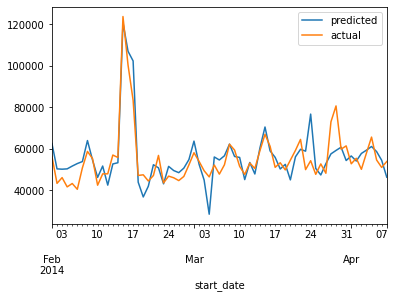

In [0]:
# Get Accuracy over Time for FD=1, Averaged for all series
acc_plot_FD1_Avg = top_model.get_accuracy_over_time_plot(backtest=0,
                                                          forecast_distance=1,
                                                          series_id=None)

# Convert to dataframe
df = pd.DataFrame.from_dict(acc_plot_FD1_Avg.bins)

# Plot
figure = df.plot("start_date", ["predicted","actual"]).get_figure()

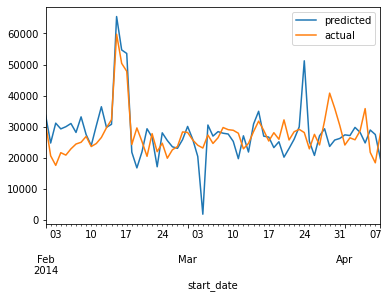

In [0]:
# Get Accuracy over Time for FD=7, For just the Baltimore store series
acc_plot_FD7_Baltimore = top_model.get_accuracy_over_time_plot(backtest=0,
                                                                forecast_distance=2,
                                                                series_id='Baltimore')

# Convert to dataframe
df = pd.DataFrame.from_dict(acc_plot_FD7_Baltimore.bins)

# Plot
figure = df.plot("start_date", ["predicted","actual"]).get_figure()

### Retrieve Feature Impact

As an example of model explainability, calculate the Feature Impact values of the model using the `get_or_request_feature_impact` function.

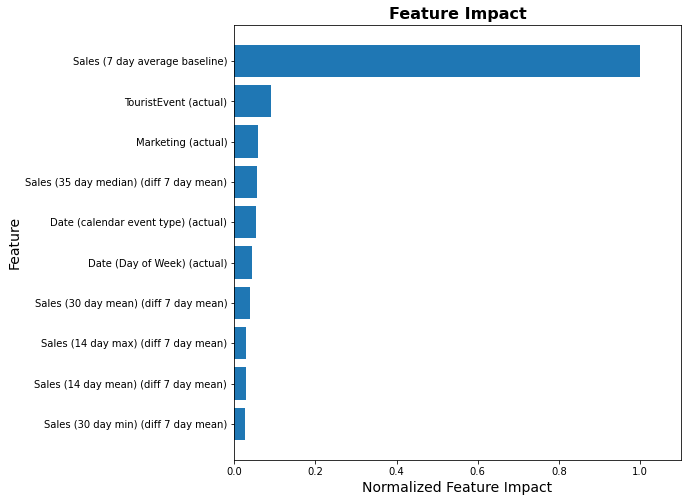

In [0]:
# Request and retrieve feature impact
feature_impacts = top_model.get_or_request_feature_impact() # Will trigger Feature Impact calculations if not done
FI_df = pd.DataFrame(feature_impacts) # Convert to dataframe

# Sort features by Normalized Feature Impact
FI_df = FI_df.sort_values(by='impactNormalized', ascending=False)

# Take top 10
FI_df = FI_df[0:10]

# Plot Feature Impact
FI_df["X axis"] = FI_df.index

# Plot
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor='w')

plt.barh(FI_df.featureName, FI_df.impactNormalized)
axes.invert_yaxis()
plt.title("Feature Impact", size=16, fontweight="bold")
plt.xlabel("Normalized Feature Impact", size=14)
plt.xlim([0,1.1])
plt.ylabel("Feature", size=14)
plt.show()

### Analyze Accuracy for each Series

The [**Series Insight**](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/series-insights-multi.html) tool provides the ability to compute the accuracy for each indivudal series. This is especially powerful to help us identify which series the model is doing particularly better or worse in forecasting.

In this demonstration, we see that the model has particularly high RMSE for the Savannah and Louisville store forecasts. We may consider refining our model by splitting those two series into a separate model as a future modeling experiment.

In [0]:
# Trigger the Series Insight computation
series_insight_job = top_model.compute_series_accuracy()
series_insight_job.wait_for_completion() # Complete job before progressing

In [0]:
# Retrieve Series Accuracy
model_series_insight = top_model.get_series_accuracy_as_dataframe(metric='RMSE', 
                                                                 order_by='backtestingScore')

# Unlist 'multiseriesValues' to 'Series' column
model_series_insight['multiseriesValues'] = model_series_insight['multiseriesValues'].apply(lambda x: x[0])
model_series_insight.rename(columns={'multiseriesValues':'Series'}, inplace=True)

# View
model_series_insight

Out[21]:

,multiseriesId,Series,rowCount,duration,startDate,endDate,validationScore,backtestingScore,holdoutScore,targetAverage
0,6505fef27eee8f1722928925,Richmond,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,7218.65873,8547.40625,None,23246.715686
1,6505fef27eee8f172292891f,Columbus,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,7456.56279,9721.56480,None,27429.998599
2,6505fef27eee8f1722928926,San Antonio,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,8114.48431,10376.49895,None,33060.633053
3,6505fef27eee8f172292891e,Baltimore,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,7845.80014,10694.34531,None,40267.324930
4,6505fef27eee8f1722928924,Portland,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,7949.69121,12929.56677,None,48098.427171
5,6505fef27eee8f1722928920,Detroit,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,9304.24204,13900.65485,None,44494.661064
6,6505fef27eee8f1722928921,Lancaster,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,8105.08651,13905.95471,None,61815.984594
7,6505fef27eee8f1722928923,Philadelphia,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,10547.99071,18394.69193,None,72770.144258
8,6505fef27eee8f1722928922,Louisville,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,17150.37130,41961.61434,None,160653.865546
9,6505fef27eee8f1722928927,Savannah,714,P1Y11M13D,2012-07-01T00:00:00.000000Z,2014-06-14T00:00:00.000000Z,25179.31388,44335.19809,None,202447.869748


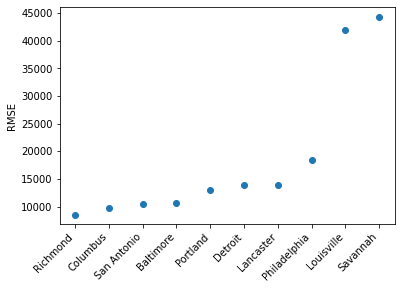

In [0]:
# Visualize the performance by stores
plt.scatter(model_series_insight["Series"], model_series_insight["backtestingScore"])
p = plt.xticks(rotation=45, horizontalalignment='right')
p = plt.ylabel('RMSE')

## Make new predictions with a test dataset

We can make new predictions directly on the leaderboard by uploading new test datasets to the project. We can then score the test dataset with any model on the leaderboard and retrieve the results.

DataRobot expects new prediction datasets to have rows for each new date we want to forecast. These rows should have values for the known-in-advance features and NA everywhere else. For example, since the model is forecasting 1-7 days out from each forecast point, we will have 7 new rows (corresponding from June 15 to June 21, 2014).

**Note: We assume the prediction data is already available within Databricks. If not, please refer to the optional setup section to download and create a temporary view of the prediction dataset.**

In [0]:
# Query and prepare data for ingest
test_df = spark.sql(""" SELECT * FROM Sales_Multiseries_prediction """)

# Convert to pandas df
test_df = test_df.toPandas()

# For time-series projects, DataRobot expects a dataset that is ordered by our Multi-series ID (e.g. Store) and Date
# We prepare our dataframe accordingly:
test_df[["Date"]] = test_df[["Date"]].apply(pd.to_datetime) # Convert Date to datetime
test_df = test_df.sort_values(by=['Store','Date']) # Order

In [0]:
# Upload data to modeling project
dataset = project.upload_dataset(test_df)

# Make test predictions on the top model
pred_job = top_model.request_predictions(dataset_id = dataset.id,
                                         include_prediction_intervals = True,
                                         prediction_intervals_size = 80)

# Get prediction results
preds = pred_job.get_result_when_complete()
preds.head(10)

Out[24]:

,row_id,prediction,forecast_distance,forecast_point,timestamp,series_id,prediction_interval_lower_bound,prediction_interval_upper_bound
0,51,26237.212567,1,2014-06-14T00:00:00.000000Z,2014-06-15T00:00:00.000000Z,Baltimore,17055.503195,33286.433636
1,52,22723.630702,2,2014-06-14T00:00:00.000000Z,2014-06-16T00:00:00.000000Z,Baltimore,12573.503957,30842.930237
2,53,31455.859688,3,2014-06-14T00:00:00.000000Z,2014-06-17T00:00:00.000000Z,Baltimore,21661.705530,40359.731319
3,54,22076.163114,4,2014-06-14T00:00:00.000000Z,2014-06-18T00:00:00.000000Z,Baltimore,11813.151972,32430.925983
4,55,27252.311494,5,2014-06-14T00:00:00.000000Z,2014-06-19T00:00:00.000000Z,Baltimore,16178.230046,38416.261111
5,56,18951.425027,6,2014-06-14T00:00:00.000000Z,2014-06-20T00:00:00.000000Z,Baltimore,7887.020240,31468.635540
6,57,34483.893802,7,2014-06-14T00:00:00.000000Z,2014-06-21T00:00:00.000000Z,Baltimore,22732.681377,47505.715896
7,109,21889.020069,1,2014-06-14T00:00:00.000000Z,2014-06-15T00:00:00.000000Z,Columbus,13255.058417,31087.237359
8,110,18330.570972,2,2014-06-14T00:00:00.000000Z,2014-06-16T00:00:00.000000Z,Columbus,8426.425216,27306.256618
9,111,27065.079983,3,2014-06-14T00:00:00.000000Z,2014-06-17T00:00:00.000000Z,Columbus,17042.123869,36245.250333


## Deploy a model with monitoring in MLOps

With a single function call or click on the UI, DataRobot can quickly deploy models into production while fully reproducing the entire modeling pipeline including the necessary data preprocessing steps utilized by the blueprints and any advanced feature engineering that are part of the project. Once deployed, you can call the DataRobot REST or Python API to make batch and real-time predictions. You can also configure and schedule recurring batch prediction jobs that write back into a database.

Once a model is deployed, you can access MLOps monitoring capabilities such as:

* Service health
* Data drift
* Prediction accuracy
* Model retraining

To deploy a model, call the `create_from_learning_model` function and provide the ID of the model you want to deploy and the ID of the prediction server you want to deploy into.

For additional information, please see documentation for:

1. [**MLOps monitoring**](https://docs.datarobot.com/en/docs/mlops/mlops-overview.html) 
2. [**Available prediction methods**](https://docs.datarobot.com/en/docs/predictions/index.html)
3. [**Other deployment workflows with DataRobot**](https://docs.datarobot.com/en/docs/mlops/deployment/deploy-workflows/index.html)

**Note: This demo assumes you have a prediction server available, such as in the DataRobot managed cloud instance. Please check that you have an accessible prediction server for your account and that you have available deployment slots before continuing.**

In [0]:
# Set the prediction server to deploy to
prediction_server_id = dr.PredictionServer.list()[0].id # EDIT THIS BASED ON THE PREDICTION SERVERS AVAILABLE TO YOU

# Set deployment details
deployment = dr.Deployment.create_from_learning_model( 
    model_id=top_model.id, 
    label='[AIA] Multi-Store Forecasting Deployment', 
    description='[AIA] Multi Store Forecasting Deployment', 
    default_prediction_server_id=prediction_server_id
)

Every deployment in DataRobot is assigned a **deployment ID** which you can use to reference/retrieve the deployment via the API.

In [0]:
# Quick link to the deployment you just created
print("DataRobot Deployment URL: " + deployment.get_uri())
print("Deployment ID: " + deployment.id)

DataRobot Deployment URL: https://app.datarobot.com/deployments/65060454c634c838c921f23a/overview
Deployment ID: 65060454c634c838c921f23a

### Configure model monitoring

In this example, we set up the deployment to monitor data drift. We use the following API call:

* Data drift: `update_drift_tracking_settings`

We additionally enable and set the deployment to return (alongside the forecast):
* Prediction intervals: `update_prediction_intervals_settings`
* Prediction explanations: `PredictionExplanationsInitialization.create`

In [0]:
# Turn on Data Drift tracking for features and the target
deployment.update_drift_tracking_settings(target_drift_enabled=True, 
                                          feature_drift_enabled=True)

In [0]:
# For time-series deployments, we can also set the prediction intervals for each forecast.
deployment.update_prediction_intervals_settings(percentiles=[95], 
                                                enabled=True)

In [0]:
# In order to compute prediction explanations at time of predictions, initialize it for the best model
dr.PredictionExplanationsInitialization.create(project_id=project.id, 
                                               model_id=top_model.id)

Out[29]: Job(predictionExplanationsInitialization, status=inprogress)

## Forecast predictions via the Prediction API

The [Batch Prediction API](https://docs.datarobot.com/en/docs/api/reference/batch-prediction-api/index.html) provides flexible options for intake and output when scoring large datasets using the prediction servers you have already deployed. The API is exposed through the DataRobot Public API and can be consumed using  any REST-enabled client or the DataRobot Python Public API bindings.

To ensure the Batch Prediction API can process your time series dataset, you must configure the following:
* Sort prediction rows by their timestamps, with the earliest row first.
* If using multiseries, the prediction rows must be sorted by series ID then timestamp.
* There is no limit on the number of series DataRobot supports. For more information, see [Time series data requirements for batch predictions via API](https://docs.datarobot.com/en/docs/api/reference/batch-prediction-api/batch-pred-ts.html).

Use the following cell to make forecast predictions on the 'test_df' data by calling the API endpoint directly and writing results back to pandas dataframe.

In [0]:
job, predictions = dr.BatchPredictionJob.score_pandas(deployment.id, # Deployment ID
                                                      test_df, # Scoring dataset
                                                      max_explanations=3) # If prediction explanations are required

print("Started scoring...", job)
job.wait_for_completion()

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6506058663c3c4b19d7dd8bf
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Started scoring... BatchPredictionJob(batchPredictions, '6506058663c3c4b19d7dd8bf', status=INITIALIZING)

In [0]:
# Take a look at our prediction results
# Format the prediction output. Select specific columns we want to view
select_predictions_df = predictions[['Store_y','FORECAST_POINT','Date_y','Sales (actual)_PREDICTION', 'PREDICTION_95_PERCENTILE_LOW',
                                      'PREDICTION_95_PERCENTILE_HIGH', 'Marketing', 'EXPLANATION_1_FEATURE_NAME', 'EXPLANATION_2_FEATURE_NAME']]
select_predictions_df = select_predictions_df.rename(columns={"Store_y": "Store", "Date_y": "Date"})

# Output predictions for the next seven days for two stores
select_predictions_df.head(14)

Out[31]:

,Store,FORECAST_POINT,Date,Sales (actual)_PREDICTION,PREDICTION_95_PERCENTILE_LOW,PREDICTION_95_PERCENTILE_HIGH,Marketing,EXPLANATION_1_FEATURE_NAME,EXPLANATION_2_FEATURE_NAME
514,Baltimore,2014-06-14T00:00:00Z,2014-06-15T00:00:00.000000Z,26237.212567,12643.847654,44557.544170,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
515,Baltimore,2014-06-14T00:00:00Z,2014-06-16T00:00:00.000000Z,22723.630702,5153.240741,42836.544800,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
516,Baltimore,2014-06-14T00:00:00Z,2014-06-17T00:00:00.000000Z,31455.859688,13928.286602,52519.873156,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
517,Baltimore,2014-06-14T00:00:00Z,2014-06-18T00:00:00.000000Z,22076.163114,4918.524689,44673.982658,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Sales (14 day max) (diff 7 day mean)
518,Baltimore,2014-06-14T00:00:00Z,2014-06-19T00:00:00.000000Z,27252.311494,9795.999462,49711.243074,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
519,Baltimore,2014-06-14T00:00:00Z,2014-06-20T00:00:00.000000Z,18951.425027,2923.360338,42656.593238,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
520,Baltimore,2014-06-14T00:00:00Z,2014-06-21T00:00:00.000000Z,34483.893802,19585.277892,57196.283847,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Date (Day of Week) (actual)
340,Columbus,2014-06-14T00:00:00Z,2014-06-15T00:00:00.000000Z,21889.020069,6737.596291,34815.621911,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
341,Columbus,2014-06-14T00:00:00Z,2014-06-16T00:00:00.000000Z,18330.570972,2553.013314,29713.096581,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)
342,Columbus,2014-06-14T00:00:00Z,2014-06-17T00:00:00.000000Z,27065.079983,11234.897123,41503.344337,Promo In Store Credit Card Signup Discount; ID...,Sales (7 day average baseline),Marketing (actual)


## Clean up

To remove everything added in the DataRobot platform as part of this notebook, run the following cell. If you want to delete any tables created in Snowflake as a result of running this notebook, you will need to manually do so in Snowflake.

In [0]:
# # CLEAN UP - Uncomment and run this cell to remove everything you added during this session

# deployment.delete()
# project.delete()
# CALENDAR.delete(CALENDAR.id)
# new_dataset.delete(new_dataset.id)

## Additional Resources

* The [DataRobot AI Accelerator Library](https://community.datarobot.com/t5/ai-accelerators-library/tkb-p/ai-accelerators-library) has similar accelerators for other [Ecosystem Integrations](https://community.datarobot.com/t5/ai-accelerators-library/tkb-p/ai-accelerators-library/label-name/ecosystem%20integration%20templates) to use DataRobot with other tools (e.g. AWS, GCP, Azure, etc) as well as accelerators for more advanced time-series applications.
* The [DataRobot API user guide](https://docs.datarobot.com/en/docs/api/guide/python/index.html) provides code examples covering topics such as model factories, classification problems, feature impact rank ensembling, and more.
* Learn how to [schedule notebooks in Databricks](https://docs.databricks.com/notebooks/schedule-notebook-jobs.html).

To learn more about advanced workflows for handling complex and large scale time series problems:
* [Time series clustering](https://docs.datarobot.com/en/docs/modeling/time/ts-clustering.html#time-series-clustering)
* [Segmented modeling](https://docs.datarobot.com/en/docs/modeling/time/ts-segmented.html)